# DataLoaderKGAT

In [12]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [13]:
import os
import sys
import random
from time import time

import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

from model.KGAT import KGAT
from parser.parser_kgat import *
from utils.log_helper import *
from utils.metrics import *
from utils.model_helper import *
# from data_loader.loader_kgat import DataLoaderKGAT

In [18]:
import os
import random
import collections

import torch
import numpy as np
import pandas as pd
import scipy.sparse as sp

from data_loader.loader_base import DataLoaderBase

class DataLoaderKGAT(DataLoaderBase):
    def __init__(self, args, logging):
        super().__init__(args, logging)
        self.cf_batch_size = args.cf_batch_size
        self.kg_batch_size = args.kg_batch_size
        self.test_batch_size = args.test_batch_size

        self.kg_data = self.load_kg(self.kg_file)
        # self.construct_data(kg_data)
        # self.print_info(logging)

        self.laplacian_type = args.laplacian_type
        # self.create_adjacency_dict()
        # self.create_laplacian_dict()
        
    def construct_data(self, kg_data):
        # add inverse kg data
        n_relations = max(kg_data['r']) + 1
        inverse_kg_data = kg_data.copy()
        inverse_kg_data = inverse_kg_data.rename({'h': 't', 't': 'h'}, axis='columns')
        inverse_kg_data['r'] += n_relations
        kg_data = pd.concat([kg_data, inverse_kg_data], axis=0, ignore_index=True, sort=False)

        # re-map user id
        kg_data['r'] += 2
        self.n_relations = max(kg_data['r']) + 1
        self.n_entities = max(max(kg_data['h']), max(kg_data['t'])) + 1
        self.n_users_entities = self.n_users + self.n_entities

        self.cf_train_data = (np.array(list(map(lambda d: d + self.n_entities, self.cf_train_data[0]))).astype(np.int32), self.cf_train_data[1].astype(np.int32))
        self.cf_test_data = (np.array(list(map(lambda d: d + self.n_entities, self.cf_test_data[0]))).astype(np.int32), self.cf_test_data[1].astype(np.int32))

        self.train_user_dict = {k + self.n_entities: np.unique(v).astype(np.int32) for k, v in self.train_user_dict.items()}
        self.test_user_dict = {k + self.n_entities: np.unique(v).astype(np.int32) for k, v in self.test_user_dict.items()}

        # add interactions to kg data
        cf2kg_train_data = pd.DataFrame(np.zeros((self.n_cf_train, 3), dtype=np.int32), columns=['h', 'r', 't'])
        cf2kg_train_data['h'] = self.cf_train_data[0]
        cf2kg_train_data['t'] = self.cf_train_data[1]

        inverse_cf2kg_train_data = pd.DataFrame(np.ones((self.n_cf_train, 3), dtype=np.int32), columns=['h', 'r', 't'])
        inverse_cf2kg_train_data['h'] = self.cf_train_data[1]
        inverse_cf2kg_train_data['t'] = self.cf_train_data[0]

        self.kg_train_data = pd.concat([kg_data, cf2kg_train_data, inverse_cf2kg_train_data], ignore_index=True)
        self.n_kg_train = len(self.kg_train_data)

        # construct kg dict
        h_list = []
        t_list = []
        r_list = []

        self.train_kg_dict = collections.defaultdict(list)
        self.train_relation_dict = collections.defaultdict(list)

        for row in self.kg_train_data.iterrows():
            h, r, t = row[1]
            h_list.append(h)
            t_list.append(t)
            r_list.append(r)

            self.train_kg_dict[h].append((t, r))
            self.train_relation_dict[r].append((h, t))

        self.h_list = torch.LongTensor(h_list)
        self.t_list = torch.LongTensor(t_list)
        self.r_list = torch.LongTensor(r_list)
        

In [29]:
args = parse_kgat_args()

# Custom args for testing
args.use_pretrain = 0

data = DataLoaderKGAT(args, logging)

In [30]:
data.n_users, data.n_items, data.n_cf_train, data.n_cf_test, data.n_cf_train+data.n_cf_test
fullSize = data.n_users * data.n_items
validity = data.n_cf_train+data.n_cf_test
print(f"Sparsity={(1.0 - validity / fullSize) * 100.0:.3f}%")

Sparsity=99.952%


,h,r,t
0,24915,0,24916
1,24917,1,5117
2,24918,0,24917
3,24919,1,24920
4,24921,2,24922
...,...,...,...
2557741,55167,3,24942
2557742,24925,1,67332
2557743,41753,0,24942
2557744,24923,1,97956


array([[<AxesSubplot:title={'center':'h'}>,
        <AxesSubplot:title={'center':'r'}>,
        <AxesSubplot:title={'center':'t'}>]], dtype=object)

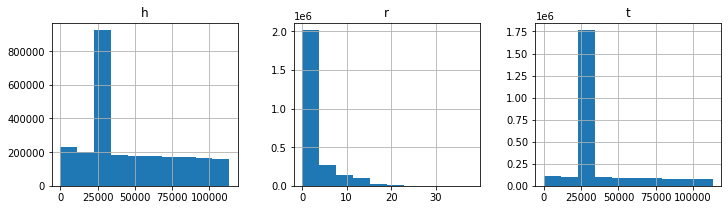

In [31]:
display(data.kg_data)
data.kg_data.describe().apply(lambda s: s.apply('{0:.2f}'.format))
display(data.kg_data.hist(figsize=(12,3), layout=(1,3)))

In [32]:
    kg_data = data.kg_data

    # add inverse kg data
    n_relations = max(kg_data['r']) + 1
    inverse_kg_data = kg_data.copy()
    inverse_kg_data = inverse_kg_data.rename({'h': 't', 't': 'h'}, axis='columns')
    inverse_kg_data['r'] += n_relations
    kg_data = pd.concat([kg_data, inverse_kg_data], axis=0, ignore_index=True, sort=False)

,h,r,t
0,24915,0,24916
1,24917,1,5117
2,24918,0,24917
3,24919,1,24920
4,24921,2,24922
...,...,...,...
5115487,24942,42,55167
5115488,67332,40,24925
5115489,24942,39,41753
5115490,97956,40,24923


array([[<AxesSubplot:title={'center':'h'}>,
        <AxesSubplot:title={'center':'r'}>,
        <AxesSubplot:title={'center':'t'}>]], dtype=object)

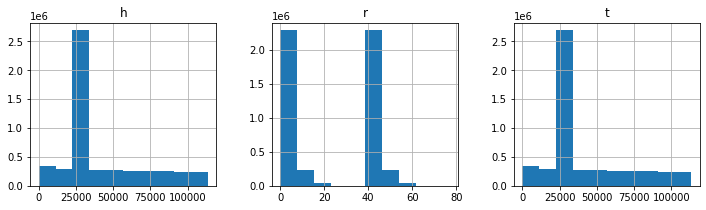

In [33]:
display(kg_data)
kg_data.describe().apply(lambda s: s.apply('{0:.2f}'.format))
display(kg_data.hist(figsize=(12,3), layout=(1,3)))

In [34]:
    # re-map user id
    kg_data['r'] += 2
    data.n_relations = max(kg_data['r']) + 1
    data.n_entities = max(max(kg_data['h']), max(kg_data['t'])) + 1
    data.n_users_entities = data.n_users + data.n_entities

    data.cf_train_data = (np.array(list(map(lambda d: d + data.n_entities, data.cf_train_data[0]))).astype(np.int32), data.cf_train_data[1].astype(np.int32))
    data.cf_test_data = (np.array(list(map(lambda d: d + data.n_entities, data.cf_test_data[0]))).astype(np.int32), data.cf_test_data[1].astype(np.int32))

    data.train_user_dict = {k + data.n_entities: np.unique(v).astype(np.int32) for k, v in data.train_user_dict.items()}
    data.test_user_dict = {k + data.n_entities: np.unique(v).astype(np.int32) for k, v in data.test_user_dict.items()}

In [35]:
    # add interactions to kg data
    cf2kg_train_data = pd.DataFrame(np.zeros((data.n_cf_train, 3), dtype=np.int32), columns=['h', 'r', 't'])
    cf2kg_train_data['h'] = data.cf_train_data[0]
    cf2kg_train_data['t'] = data.cf_train_data[1]

    inverse_cf2kg_train_data = pd.DataFrame(np.ones((data.n_cf_train, 3), dtype=np.int32), columns=['h', 'r', 't'])
    inverse_cf2kg_train_data['h'] = data.cf_train_data[1]
    inverse_cf2kg_train_data['t'] = data.cf_train_data[0]

    data.kg_train_data = pd.concat([kg_data, cf2kg_train_data, inverse_cf2kg_train_data], ignore_index=True)
    data.n_kg_train = len(data.kg_train_data)

,h,r,t
0,24915,2,24916
1,24917,3,5117
2,24918,2,24917
3,24919,3,24920
4,24921,4,24922
...,...,...,...
6420515,15786,1,184165
6420516,3631,1,184165
6420517,6576,1,184165
6420518,15701,1,184165


array([[<AxesSubplot:title={'center':'h'}>,
        <AxesSubplot:title={'center':'r'}>,
        <AxesSubplot:title={'center':'t'}>]], dtype=object)

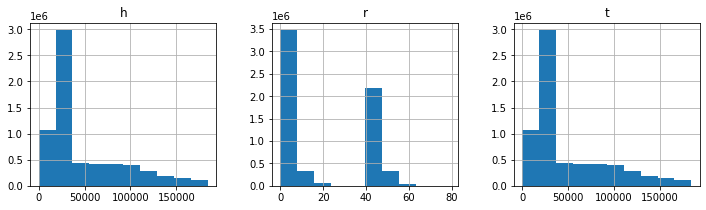

In [36]:
display(data.kg_train_data)
data.kg_train_data.describe().apply(lambda s: s.apply('{0:.2f}'.format))
display(data.kg_train_data.hist(figsize=(12,3), layout=(1,3)))

In [37]:
    # construct kg dict
    h_list = []
    t_list = []
    r_list = []

    data.train_kg_dict = collections.defaultdict(list)
    data.train_relation_dict = collections.defaultdict(list)

    for row in data.kg_train_data.iterrows():
        h, r, t = row[1]
        h_list.append(h)
        t_list.append(t)
        r_list.append(r)

        data.train_kg_dict[h].append((t, r))
        data.train_relation_dict[r].append((h, t))

    data.h_list = torch.LongTensor(h_list)
    data.t_list = torch.LongTensor(t_list)
    data.r_list = torch.LongTensor(r_list)